In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from pyod.models.knn import KNN
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

In [210]:
data = pd.read_csv("../outputs/clean_houses.csv", index_col=0)

In [211]:
data.head()

,neighborhood_id,house_type_id,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,buy_price,buy_price_by_area,latitude,longitude
0,"San Cristóbal, Villaverde(Madrid)",HouseType 1: Pisos,False,False,64.0,2,1.0,3,True,False,False,False,False,False,False,85000,1328,40.343263,-3.688352
1,"Los Ángeles, Villaverde(Madrid)",HouseType 1: Pisos,True,False,70.0,3,1.0,4,True,True,False,False,True,False,False,129900,1856,40.355109,-3.700105
2,"San Andrés, Villaverde(Madrid)",HouseType 1: Pisos,False,False,94.0,2,2.0,1,True,True,False,True,False,False,False,144247,1535,40.345539,-3.710970
3,"San Andrés, Villaverde(Madrid)",HouseType 1: Pisos,False,False,64.0,2,1.0,Bajo,True,True,False,True,False,False,False,109900,1717,40.345539,-3.710970
4,"Los Rosales, Villaverde(Madrid)",HouseType 1: Pisos,False,False,108.0,2,2.0,4,True,True,True,True,False,False,True,260000,2407,40.355841,-3.688399


In [212]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17398 entries, 0 to 17397
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   neighborhood_id     17398 non-null  object 
 1   house_type_id       17398 non-null  object 
 2   is_renewal_needed   17398 non-null  bool   
 3   is_new_development  17398 non-null  bool   
 4   sq_mt_built         17398 non-null  float64
 5   n_rooms             17398 non-null  int64  
 6   n_bathrooms         17398 non-null  float64
 7   floor               17398 non-null  object 
 8   is_exterior         17398 non-null  bool   
 9   has_lift            17398 non-null  bool   
 10  has_parking         17398 non-null  bool   
 11  has_storage_room    17398 non-null  bool   
 12  has_terrace         17398 non-null  bool   
 13  has_balcony         17398 non-null  bool   
 14  has_pool            17398 non-null  bool   
 15  buy_price           17398 non-null  int64  
 16  buy_

# Para realizar nuestro predictor de precios de pisos, vamos a acotar los datos a los que suelen ser standard. Para ello, vamos a echar un pequeño vistazo a los datos que componen nuestro dataset.

In [213]:
data.house_type_id.value_counts()

HouseType 1: Pisos     15858
HouseType 5: Áticos      910
HouseType 4: Dúplex      630
Name: house_type_id, dtype: int64

### La gran mayoría de los datos se corresponden con la tipología pisos, por lo que vamos a eliminar el resto de tipologías

In [214]:
data = data.drop(data[data["house_type_id"]=="HouseType 4: Dúplex"].index)
data = data.drop(data[data["house_type_id"]=="HouseType 5: Áticos"].index)

### Transformamos ahora la columna pisos a datos numéricos.

In [215]:
planta={"Bajo": 0,
       "Entreplanta exterior": -1,
        "Entreplanta interior": -1,
       "Semi-sótano exterior": -2,    
        "Semi-sótano interior": -2,   
        "Sótano interior": -3,          
        "Sótano exterior": -3}

In [216]:
data.floor = data.floor.apply(lambda x: planta.get(x, x))

In [217]:
data.floor = pd.to_numeric(data.floor)

In [218]:
# Vamos a realizar ahora un análisis estadístico de los datos numéricos.

data.describe()

,sq_mt_built,n_rooms,n_bathrooms,floor,buy_price,buy_price_by_area,latitude,longitude
count,15858.000000,15858.000000,15858.000000,15858.000000,1.585800e+04,15858.000000,15858.000000,15858.000000
mean,120.263085,2.868773,1.828415,2.498928,5.403210e+05,4046.152541,40.423061,-3.688877
std,81.550413,1.214570,1.001548,2.035698,5.901108e+05,1903.335924,0.035340,0.036562
min,16.000000,0.000000,1.000000,-3.000000,3.600000e+04,447.000000,40.339934,-3.828783
25%,70.000000,2.000000,1.000000,1.000000,1.900000e+05,2565.000000,40.397292,-3.708916
50%,95.000000,3.000000,2.000000,2.000000,3.480000e+05,3800.500000,40.424816,-3.693014
75%,140.000000,3.000000,2.000000,4.000000,6.366000e+05,5051.000000,40.445414,-3.667970
max,894.000000,15.000000,14.000000,9.000000,8.500000e+06,18889.000000,40.520554,-3.546616


### Del anterior análisis, vamos a quedarnos con los datos que tenemos entre el percentil 25% y el percentil 75% que es donde se concentran la gran mayoría de los datos.

In [219]:
data = data.drop(data[data["buy_price"]>1000000].index)
data = data.drop(data[data["sq_mt_built"]<50].index)
data = data.drop(data[data["sq_mt_built"]>200].index)#140
#data = data.drop(data[data["n_rooms"]<1].index)
data = data.drop(data[data["n_rooms"]>3].index)
data = data.drop(data[data["n_bathrooms"]<1].index)
data = data.drop(data[data["n_bathrooms"]>3].index)#2
data = data.drop(data[data["floor"]<0].index)
data = data.drop(data[data["floor"]>8].index)

In [220]:
data.describe()

,sq_mt_built,n_rooms,n_bathrooms,floor,buy_price,buy_price_by_area,latitude,longitude
count,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000
mean,88.933066,2.406400,1.456111,2.451805,329503.330952,3610.488795,40.418242,-3.687556
std,28.518005,0.678445,0.541402,1.845336,198020.857700,1619.817965,0.037808,0.040113
min,50.000000,0.000000,1.000000,0.000000,36000.000000,447.000000,40.339934,-3.828783
25%,67.000000,2.000000,1.000000,1.000000,170000.000000,2292.000000,40.388788,-3.710970
50%,82.000000,3.000000,1.000000,2.000000,272000.000000,3298.000000,40.415129,-3.694300
75%,106.000000,3.000000,2.000000,4.000000,449000.000000,4615.000000,40.445414,-3.664238
max,200.000000,3.000000,3.000000,8.000000,1000000.000000,12923.000000,40.520554,-3.546616


In [221]:
def transf(column):

    le = preprocessing.LabelEncoder()
    data[column] = le.fit_transform(data[column])
    return data[column]

In [222]:
transf("house_type_id")
transf("is_renewal_needed")
transf("is_new_development")
transf("is_exterior")
transf("has_lift")
transf("has_parking")
transf("has_storage_room")
transf("has_terrace")
transf("has_balcony")
transf("has_pool");

In [223]:
data.head()

,neighborhood_id,house_type_id,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,buy_price,buy_price_by_area,latitude,longitude
0,"San Cristóbal, Villaverde(Madrid)",0,0,0,64.0,2,1.0,3,1,0,0,0,0,0,0,85000,1328,40.343263,-3.688352
1,"Los Ángeles, Villaverde(Madrid)",0,1,0,70.0,3,1.0,4,1,1,0,0,1,0,0,129900,1856,40.355109,-3.700105
2,"San Andrés, Villaverde(Madrid)",0,0,0,94.0,2,2.0,1,1,1,0,1,0,0,0,144247,1535,40.345539,-3.710970
3,"San Andrés, Villaverde(Madrid)",0,0,0,64.0,2,1.0,0,1,1,0,1,0,0,0,109900,1717,40.345539,-3.710970
4,"Los Rosales, Villaverde(Madrid)",0,0,0,108.0,2,2.0,4,1,1,1,1,0,0,1,260000,2407,40.355841,-3.688399


In [224]:
data.loc[data["neighborhood_id"]=="Malasaña-Universidad, Centro(Madrid)"]

,neighborhood_id,house_type_id,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,buy_price,buy_price_by_area,latitude,longitude
13588,"Malasaña-Universidad, Centro(Madrid)",0,0,0,106.0,2,2.0,2,1,1,0,0,0,0,0,565000,5330,40.426708,-3.704231
13590,"Malasaña-Universidad, Centro(Madrid)",0,0,0,79.0,2,2.0,0,1,1,0,0,0,0,0,450000,5696,40.426708,-3.704231
13611,"Malasaña-Universidad, Centro(Madrid)",0,0,0,142.0,2,1.0,1,1,1,0,0,0,1,0,550000,3873,40.426708,-3.704231
13621,"Malasaña-Universidad, Centro(Madrid)",0,0,0,153.0,3,2.0,4,1,1,0,0,0,1,0,775000,5065,40.426708,-3.704231
13632,"Malasaña-Universidad, Centro(Madrid)",0,0,0,78.0,1,1.0,3,1,0,0,0,0,0,0,485000,6218,40.426708,-3.704231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17308,"Malasaña-Universidad, Centro(Madrid)",0,0,0,119.0,3,1.0,1,1,1,0,1,0,1,0,525000,4412,40.426708,-3.704231
17310,"Malasaña-Universidad, Centro(Madrid)",0,0,0,110.0,3,2.0,1,1,0,0,0,0,1,0,550000,5000,40.426708,-3.704231
17311,"Malasaña-Universidad, Centro(Madrid)",0,0,0,55.0,1,1.0,1,1,0,0,0,0,1,0,350000,6364,40.426708,-3.704231
17321,"Malasaña-Universidad, Centro(Madrid)",0,0,0,117.0,3,2.0,1,1,1,0,1,0,1,0,555000,4744,40.426708,-3.704231


In [225]:
data.columns

Index(['neighborhood_id', 'house_type_id', 'is_renewal_needed',
       'is_new_development', 'sq_mt_built', 'n_rooms', 'n_bathrooms', 'floor',
       'is_exterior', 'has_lift', 'has_parking', 'has_storage_room',
       'has_terrace', 'has_balcony', 'has_pool', 'buy_price',
       'buy_price_by_area', 'latitude', 'longitude'],
      dtype='object')

In [226]:
data = data[['is_renewal_needed',
       'is_new_development', 'sq_mt_built', 'n_rooms', 'n_bathrooms', 'floor',
       'is_exterior', 'has_lift', 'has_parking', 'has_storage_room',
       'has_terrace', 'has_balcony', 'has_pool',
       'latitude', 'longitude', 'buy_price']]

In [227]:
clf = KNN(contamination=0.5, method="largest", algorithm="auto")
clf.fit(data)
y_pred = clf.predict(data)
dropea = data[y_pred == 1]
data = data.drop(dropea.index)

In [228]:
clf = KNN(contamination=0.5, method="largest", algorithm="auto")
clf.fit(data)
y_pred = clf.predict(data)
dropea = data[y_pred == 1]
data = data.drop(dropea.index)

In [229]:
data.describe()

,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,latitude,longitude,buy_price
count,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000
mean,0.179628,0.017251,77.569551,2.349945,1.286966,2.054491,0.905257,0.606517,0.179354,0.217415,0.353779,0.153067,0.115827,40.416801,-3.692043,266369.470153
std,0.383930,0.130222,19.390573,0.671600,0.461400,1.402365,0.292899,0.488589,0.383701,0.412544,0.478207,0.360101,0.320061,0.036007,0.039018,145521.342036
min,0.000000,0.000000,50.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.339934,-3.828783,90000.000000
25%,0.000000,0.000000,63.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.388788,-3.715748,154000.000000
50%,0.000000,0.000000,74.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.410719,-3.699327,220000.000000
75%,0.000000,0.000000,87.000000,3.000000,2.000000,3.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,40.443621,-3.661223,350000.000000
max,1.000000,1.000000,160.000000,3.000000,3.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,40.520554,-3.546616,850000.000000


In [230]:
data.to_csv("..\outputs\h2o_acotados.csv")

In [231]:
"""sns.pairplot(data, size=2.5, vars=data)
plt.tight_layout()"""

'sns.pairplot(data, size=2.5, vars=data)\nplt.tight_layout()'

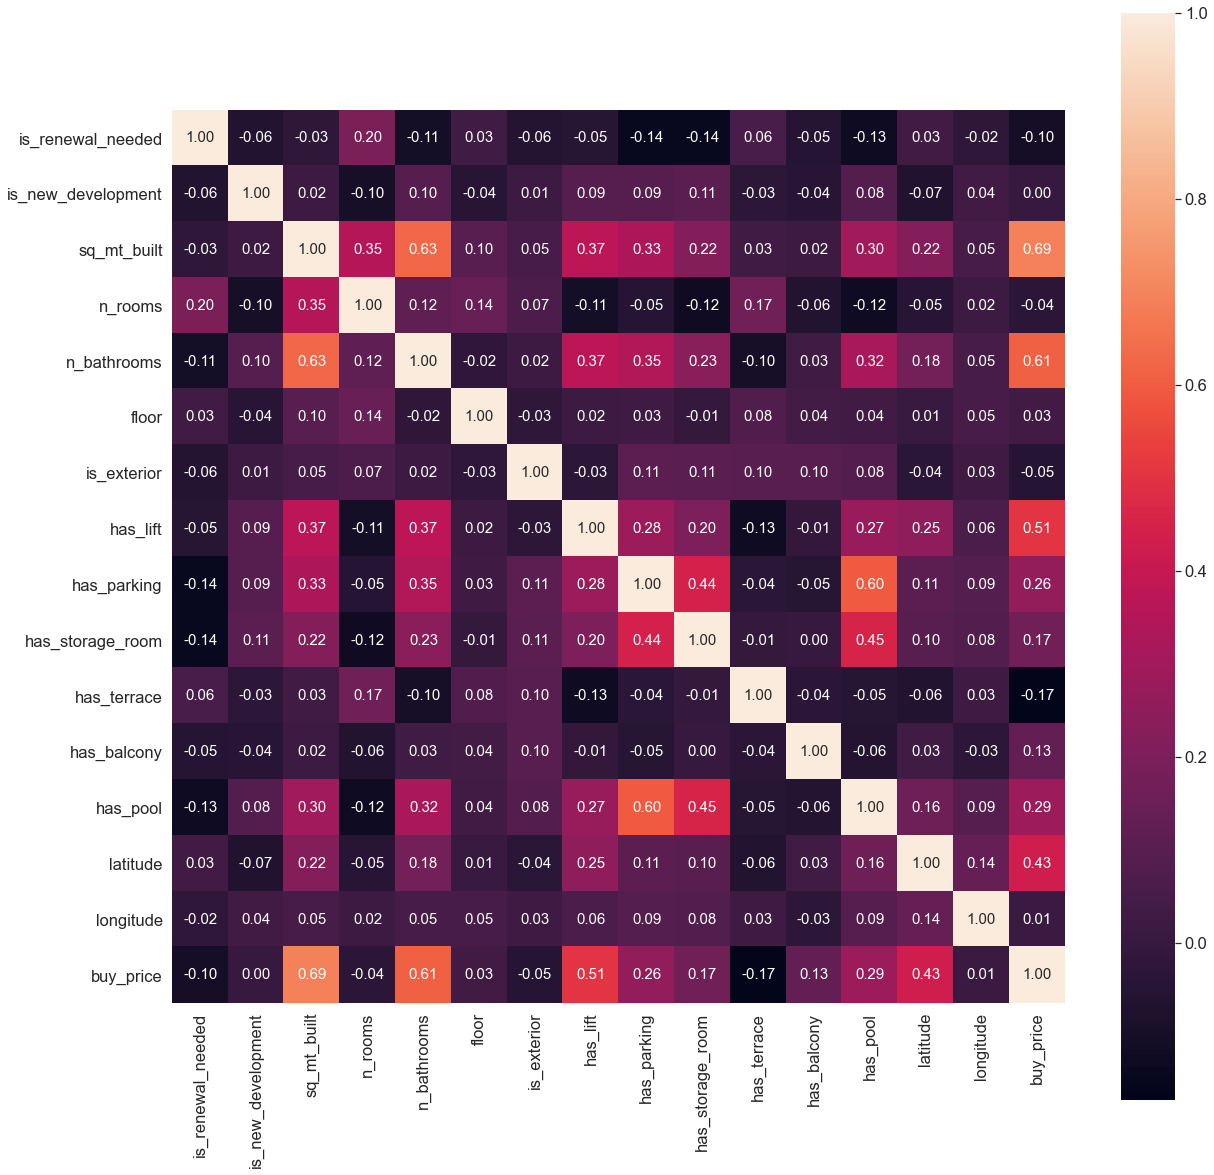

In [232]:
# Heatmap.

cm = np.corrcoef(data.values.T)
sns.set(font_scale=1.5)
plt.figure(figsize=(20, 20))
hm = sns.heatmap(cm,
                 cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=data.columns,
                xticklabels=data.columns)

In [233]:
features = data.drop(["buy_price"], axis=1)
X = features
y = data['buy_price']

In [234]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=7)

In [235]:
models = {
    "XGBRegressor" : XGBRegressor(),
    "DecisionTree" : DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "ExtraTrees" : ExtraTreesRegressor(),
    "GradientBoosting" : GradientBoostingRegressor(),
    "HistGradientBoosting": HistGradientBoostingRegressor(),
    "Voting": VotingRegressor(
        [('etr', ExtraTreesRegressor()),
         ('rf', RandomForestRegressor())]
    )
}

In [236]:
for name, model in models.items():
    print(f"Entrenando {name}")
    model.fit(X_train, y_train)
print("Proceso terminado")

Entrenando XGBRegressor
Entrenando DecisionTree
Entrenando RandomForest
Entrenando ExtraTrees
Entrenando GradientBoosting
Entrenando HistGradientBoosting
Entrenando Voting
Proceso terminado


-------XGBRegressor-------
RMSE 39896.269
R2 0.917
-------DecisionTree-------
RMSE 55613.482
R2 0.839
-------RandomForest-------
RMSE 39789.554
R2 0.918
-------ExtraTrees-------
RMSE 42165.85
R2 0.908
-------GradientBoosting-------
RMSE 43338.212
R2 0.902
-------HistGradientBoosting-------
RMSE 38679.853
R2 0.922
-------Voting-------
RMSE 39556.26
R2 0.919


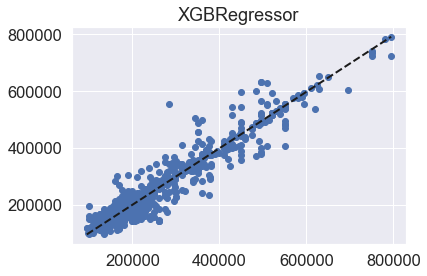

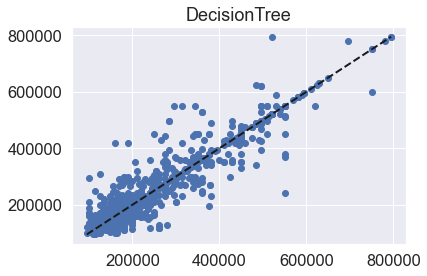

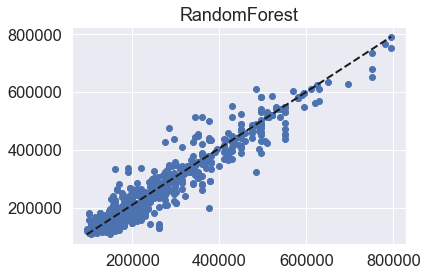

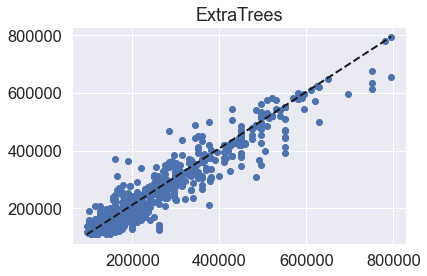

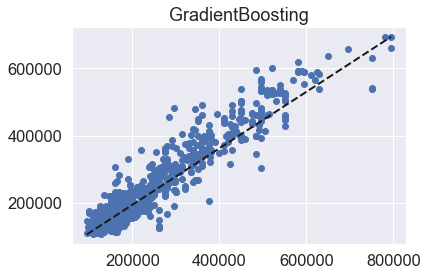

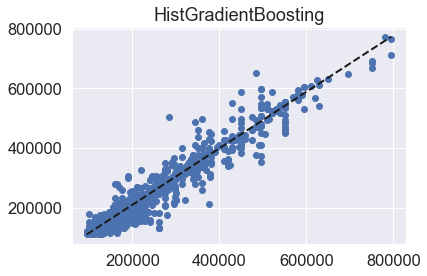

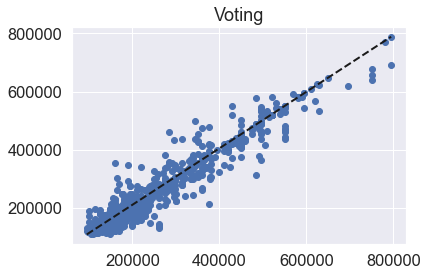

In [237]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"-------{name}-------")
    print("RMSE", round(np.sqrt(mean_squared_error(y_test,y_pred)),3))
    print("R2", round(r2_score(y_test,y_pred),3))
    plt.figure()
    plt.title(name)
    plt.scatter(y_test,y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2)

## Test con H2O

In [238]:
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 hours 20 mins
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_Javi_geldd1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,666 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [32]:
h2train = h2o.H2OFrame(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [37]:
features = data.drop(["buy_price"], axis=1)

x = list(features)
y = "buy_price"

In [38]:
from h2o.automl import H2OAutoML

automl = H2OAutoML(max_runtime_secs=1200, sort_metric='RMSE')
automl.train(x, y, training_frame=h2train)
leader_board = automl.leaderboard
leader_board.head()

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,rmse,mean_residual_deviance,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20201014_105559,36060.1,1.30033e+09,1.30033e+09,23854,0.141285
GBM_grid__1_AutoML_20201014_105559_model_3,37359.7,1.39575e+09,1.39575e+09,25116.7,0.147176
GBM_4_AutoML_20201014_105559,37498.1,1.40611e+09,1.40611e+09,25311.6,0.146872
GBM_grid__1_AutoML_20201014_105559_model_96,37537.7,1.40908e+09,1.40908e+09,25607.2,0.147775
GBM_grid__1_AutoML_20201014_105559_model_4,37540.9,1.40932e+09,1.40932e+09,24344.8,0.147571
GBM_grid__1_AutoML_20201014_105559_model_25,37639,1.4167e+09,1.4167e+09,24909.5,0.146569
XGBoost_grid__1_AutoML_20201014_105559_model_18,37654.4,1.41785e+09,1.41785e+09,25032.9,0.145993
GBM_grid__1_AutoML_20201014_105559_model_56,37768.4,1.42646e+09,1.42646e+09,25587.4,0.147471
GBM_grid__1_AutoML_20201014_105559_model_83,37821.1,1.43044e+09,1.43044e+09,25529.4,0.146824
GBM_grid__1_AutoML_20201014_105559_model_28,38004.4,1.44433e+09,1.44433e+09,25677.4,0.149079


## H2O Random Forest

In [239]:
data = h2o.import_file("..\outputs\h2o_acotados.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [240]:
X = data.col_names[1:-1]
y = data.col_names[-1]

train, test =data.split_frame([0.8], seed=1234)

In [241]:
rf_h2o = H2ORandomForestEstimator()
houses_model = rf_h2o.train(X, y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [242]:
print(rf_h2o)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1602665690260_15


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,946067.0,20.0,20.0,20.0,1439.0,1553.0,1501.12




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 1720716866.8823671
RMSE: 41481.52440403278
MAE: 27124.85847582726
RMSLE: 0.16022150590002673
Mean Residual Deviance: 1720716866.8823671

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-10-14 14:15:28,0.026 sec,0.0,NaN,NaN,NaN
1,,2020-10-14 14:15:28,0.103 sec,1.0,63297.281565,38402.800673,4.006546e+09
2,,2020-10-14 14:15:28,0.153 sec,2.0,59729.339595,36486.354723,3.567594e+09
3,,2020-10-14 14:15:28,0.201 sec,3.0,58207.022938,35969.469831,3.388058e+09
4,,2020-10-14 14:15:28,0.252 sec,4.0,60172.197983,36865.235780,3.620693e+09
5,,2020-10-14 14:15:28,0.299 sec,5.0,58264.465967,36093.533188,3.394748e+09
6,,2020-10-14 14:15:28,0.346 sec,6.0,54153.214638,34418.343861,2.932571e+09
7,,2020-10-14 14:15:28,0.397 sec,7.0,53433.650374,34147.467341,2.855155e+09
8,,2020-10-14 14:15:28,0.446 sec,8.0,51839.540634,33149.403930,2.687338e+09
9,,2020-10-14 14:15:28,0.496 sec,9.0,51402.981900,33167.781841,2.642267e+09



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,sq_mt_built,7.460006e+14,1.000000,0.321503
1,latitude,5.266534e+14,0.705969,0.226971
2,n_bathrooms,4.596605e+14,0.616166,0.198099
3,longitude,1.935217e+14,0.259412,0.083402
4,has_lift,1.755299e+14,0.235295,0.075648
5,floor,4.776741e+13,0.064031,0.020586
6,n_rooms,4.108325e+13,0.055071,0.017706
7,has_pool,3.287093e+13,0.044063,0.014166
8,has_parking,2.505959e+13,0.033592,0.010800
9,has_terrace,1.995924e+13,0.026755,0.008602


In [243]:
predict = rf_h2o.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [244]:
test, predict

C1,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,latitude,longitude,buy_price
22,1,0,65,3,1,1,1,1,0,0,0,0,1,40.3558,-3.6884,150000
81,0,0,54,2,1,2,1,0,0,0,0,1,0,40.3455,-3.71097,110000
111,0,0,90,3,2,2,1,1,0,1,1,0,0,40.3551,-3.7001,195000
157,1,0,72,3,1,3,1,1,0,0,1,0,0,40.3455,-3.71097,119900
167,0,0,58,3,1,3,1,0,0,0,0,1,0,40.3399,-3.67339,105000
168,0,0,82,3,1,4,1,0,0,0,0,1,0,40.3455,-3.71097,120000
179,0,0,81,3,2,3,1,1,1,1,0,0,0,40.3455,-3.71097,155000
182,0,0,80,3,1,0,1,0,0,0,1,0,0,40.3455,-3.71097,140000
210,0,0,103,3,2,4,1,1,1,1,0,0,1,40.3558,-3.6884,250000
216,0,0,71,3,1,1,1,1,0,0,0,0,0,40.3558,-3.6884,149000


predict
178180
126660
221560
131986
108300
155439
195010
142760
291744
134345


(, )

In [245]:
print("RMSE", round(rf_h2o.model_performance(test).rmse(),3))
print("R2", round(rf_h2o.model_performance(test).r2(),3))

RMSE 36447.171
R2 0.938


## GradientBoosting

In [246]:
gbm_h2o = H2OGradientBoostingEstimator()
houses_model = gbm_h2o.train(X, y, training_frame=train)
print(gbm_h2o)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1602665690260_16


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,19802.0,5.0,5.0,5.0,13.0,32.0,26.84




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1282865644.4283783
RMSE: 35817.113848387875
MAE: 25226.462278530762
RMSLE: 0.14096303761363885
Mean Residual Deviance: 1282865644.4283783

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-10-14 14:15:40,0.010 sec,0.0,145286.182969,117569.570688,2.110807e+10
1,,2020-10-14 14:15:40,0.029 sec,1.0,133994.905798,108485.933628,1.795463e+10
2,,2020-10-14 14:15:40,0.042 sec,2.0,123618.680933,100023.048112,1.528158e+10
3,,2020-10-14 14:15:40,0.054 sec,3.0,114352.206808,92238.195796,1.307643e+10
4,,2020-10-14 14:15:40,0.061 sec,4.0,106076.017994,85267.936937,1.125212e+10
5,,2020-10-14 14:15:40,0.068 sec,5.0,98777.940033,79320.791521,9.757081e+09
6,,2020-10-14 14:15:40,0.077 sec,6.0,92331.250848,73908.054215,8.525060e+09
7,,2020-10-14 14:15:40,0.085 sec,7.0,86633.928548,69182.064678,7.505438e+09
8,,2020-10-14 14:15:40,0.093 sec,8.0,81370.261126,64918.250807,6.621119e+09
9,,2020-10-14 14:15:40,0.101 sec,9.0,76811.337107,61113.112684,5.899982e+09



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,sq_mt_built,1.150423e+14,1.000000,0.374758
1,latitude,8.633113e+13,0.750430,0.281229
2,n_bathrooms,5.373050e+13,0.467050,0.175031
3,longitude,2.425430e+13,0.210829,0.079010
4,has_lift,1.211057e+13,0.105271,0.039451
5,n_rooms,5.682826e+12,0.049398,0.018512
6,has_pool,3.255456e+12,0.028298,0.010605
7,floor,2.683535e+12,0.023327,0.008742
8,has_parking,1.576995e+12,0.013708,0.005137
9,is_renewal_needed,7.042297e+11,0.006121,0.002294


In [247]:
print("RMSE", round(gbm_h2o.rmse(),3))
print("R2", round(gbm_h2o.r2(),3))

RMSE 35817.114
R2 0.939


In [248]:
predict = gbm_h2o.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [249]:
test, predict

C1,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,latitude,longitude,buy_price
22,1,0,65,3,1,1,1,1,0,0,0,0,1,40.3558,-3.6884,150000
81,0,0,54,2,1,2,1,0,0,0,0,1,0,40.3455,-3.71097,110000
111,0,0,90,3,2,2,1,1,0,1,1,0,0,40.3551,-3.7001,195000
157,1,0,72,3,1,3,1,1,0,0,1,0,0,40.3455,-3.71097,119900
167,0,0,58,3,1,3,1,0,0,0,0,1,0,40.3399,-3.67339,105000
168,0,0,82,3,1,4,1,0,0,0,0,1,0,40.3455,-3.71097,120000
179,0,0,81,3,2,3,1,1,1,1,0,0,0,40.3455,-3.71097,155000
182,0,0,80,3,1,0,1,0,0,0,1,0,0,40.3455,-3.71097,140000
210,0,0,103,3,2,4,1,1,1,1,0,0,1,40.3558,-3.6884,250000
216,0,0,71,3,1,1,1,1,0,0,0,0,0,40.3558,-3.6884,149000


predict
194678
129576
212685
133234
115510
142393
186476
133133
274357
155049


(, )

## H2OXGBoostEstimator

In [250]:
xgbm_h2o = H2OXGBoostEstimator()
houses_model = xgbm_h2o.train(X, y, training_frame=train)
print(xgbm_h2o)

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1602665690260_17


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 482700733.31520414
RMSE: 21970.451368035297
MAE: 14997.602000658566
RMSLE: 0.09782163886682393
Mean Residual Deviance: 482700733.31520414

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-10-14 14:15:46,0.015 sec,0.0,302666.022275,265515.811353,9.160672e+10
1,,2020-10-14 14:15:46,0.037 sec,1.0,217515.363059,186770.018032,4.731293e+10
2,,2020-10-14 14:15:46,0.044 sec,2.0,157691.095680,131582.481603,2.486648e+10
3,,2020-10-14 14:15:46,0.054 sec,3.0,116370.037615,93095.157841,1.354199e+10
4,,2020-10-14 14:15:46,0.062 sec,4.0,87970.623427,67062.854792,7.738831e+09
5,,2020-10-14 14:15:46,0.072 sec,5.0,68659.451684,50249.149962,4.714120e+09
6,,2020-10-14 14:15:46,0.080 sec,6.0,55710.249296,39634.513665,3.103632e+09
7,,2020-10-14 14:15:46,0.089 sec,7.0,47584.572653,33248.397309,2.264292e+09
8,,2020-10-14 14:15:46,0.097 sec,8.0,42215.361988,29309.580725,1.782137e+09
9,,2020-10-14 14:15:46,0.106 sec,9.0,38587.449921,26747.855615,1.488991e+09



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,sq_mt_built,3.596227e+13,1.000000,0.318359
1,latitude,3.217118e+13,0.894581,0.284798
2,n_bathrooms,2.616337e+13,0.727523,0.231614
3,longitude,9.682535e+12,0.269241,0.085716
4,has_lift,3.866245e+12,0.107508,0.034226
5,n_rooms,1.338137e+12,0.037209,0.011846
6,has_pool,9.829847e+11,0.027334,0.008702
7,floor,9.335161e+11,0.025958,0.008264
8,has_parking,7.012625e+11,0.019500,0.006208
9,is_renewal_needed,3.181862e+11,0.008848,0.002817


In [251]:
print("RMSE", round(xgbm_h2o.rmse(),3))
print("R2", round(xgbm_h2o.r2(),3))

RMSE 21970.451
R2 0.977


In [252]:
print("RMSE: ", xgbm_h2o.model_performance(test).rmse())
print("R2: ", xgbm_h2o.model_performance(test).r2())

RMSE:  36637.72036363929
R2:  0.937317089294653


In [253]:
predict = xgbm_h2o.predict(test)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [254]:
test, predict

C1,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,latitude,longitude,buy_price
22,1,0,65,3,1,1,1,1,0,0,0,0,1,40.3558,-3.6884,150000
81,0,0,54,2,1,2,1,0,0,0,0,1,0,40.3455,-3.71097,110000
111,0,0,90,3,2,2,1,1,0,1,1,0,0,40.3551,-3.7001,195000
157,1,0,72,3,1,3,1,1,0,0,1,0,0,40.3455,-3.71097,119900
167,0,0,58,3,1,3,1,0,0,0,0,1,0,40.3399,-3.67339,105000
168,0,0,82,3,1,4,1,0,0,0,0,1,0,40.3455,-3.71097,120000
179,0,0,81,3,2,3,1,1,1,1,0,0,0,40.3455,-3.71097,155000
182,0,0,80,3,1,0,1,0,0,0,1,0,0,40.3455,-3.71097,140000
210,0,0,103,3,2,4,1,1,1,1,0,0,1,40.3558,-3.6884,250000
216,0,0,71,3,1,1,1,1,0,0,0,0,0,40.3558,-3.6884,149000


predict
182744
131846
199550
121117
90492.3
144691
176522
140670
294207
125606


(, )

# Tasación.

In [300]:
vivienda = {'neighborhood_id': "Malasaña-Universidad, Centro(Madrid)", # Uno del desplegable.
            'is_renewal_needed': True,     # True or False.
            'is_new_development': True,    # True or False.
            'sq_mt_built': 106,              # Valores inferiores a 140m2.
            'n_rooms': 2,                   # Valores inferiores a 3.
            'n_bathrooms': 2,               # Valores inferiores a 2.
            'floor': 4,                     # Del bajo a la 9ª planta.
            'is_exterior':False,            # True or False.
            'has_lift': True,               # True or False.
            'has_parking': True,            # True or False.
            'has_storage_room': True,       # True or False.
            'has_terrace': True,            # True or False.
            'has_balcony': True,            # True or False.
            'has_pool': True              # True or False.        
           }

In [301]:
geolocator = Nominatim(user_agent="http")

locate = geolocator.geocode(vivienda["neighborhood_id"], timeout=7)
vivienda["latitude"] = locate.latitude
vivienda["longitude"] = locate.longitude

In [302]:
vivienda.pop("neighborhood_id")
vivienda

{'is_renewal_needed': True,
 'is_new_development': True,
 'sq_mt_built': 106,
 'n_rooms': 2,
 'n_bathrooms': 2,
 'floor': 4,
 'is_exterior': False,
 'has_lift': True,
 'has_parking': True,
 'has_storage_room': True,
 'has_terrace': True,
 'has_balcony': True,
 'has_pool': True,
 'latitude': 40.4267079,
 'longitude': -3.7042311}

In [303]:
piso = pd.DataFrame.from_dict(vivienda, orient='index').T
piso

,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,latitude,longitude
0,True,True,106,2,2,4,False,True,True,True,True,True,True,40.4267,-3.70423


In [304]:
def transf(column):

    le = preprocessing.LabelEncoder()
    piso[column] = le.fit_transform(piso[column])
    return piso[column]

In [305]:
transf("is_renewal_needed")
transf("is_new_development")
transf("is_exterior")
transf("has_lift")
transf("has_parking")
transf("has_storage_room")
transf("has_terrace")
transf("has_balcony")
transf("has_pool");

In [306]:
piso.to_csv("..\outputs\new_piso.csv")

In [307]:
piso = h2o.import_file("..\outputs\new_piso.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [371]:
estimated_price = xgbm_h2o.predict(piso)
a = estimated_price.as_data_frame()
b = str(a["predict"])
import re
c = re.findall(r"\d+",b)
c[1]

xgboost prediction progress: |████████████████████████████████████████████| 100%


'504830'

In [ ]:
compara = pd.DataFrame({"y_test": y_test, "y_pred": y_pred, "difference": abs(y_test - y_pred)})

In [ ]:
data = pd.concat([data, compara.reindex(compara.index)], axis=1)
data = data.dropna(how='any')

In [ ]:
data.sort_values(by="difference", ascending=False)

In [ ]:
good = data[data.difference<50000]

In [ ]:
good